In [1]:
from mriqa_dataset import MRIQADataset
from tqdm.auto import tqdm

dataset = MRIQADataset(
    '.',    # path to save data to
    modalities=(['T1', 'T2']),
    download=False,
)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



In [18]:
import torch
import random
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

from mriqa_dataset import MRIQADataset, simulate_artefacts
from networks import ClassicCNN, PhilsClassicCnn, CatNet

In [58]:
import random

def get(index, label, z, t1=True):
    if not isinstance(index, int):
        raise ValueError(f'Index "{index}" must be int, not {type(index)}')
    subject = dataset.subjects[index]
    sample = dataset._get_sample_dict_from_subject(subject)

    # choose random MR contrast
    if t1:
        sample = sample['T1'].data
    else:
        sample = sample['T2'].data

    # normalization
    sample -= torch.min(sample)
    sample /= torch.max(sample)

    # choose random slice of volume
    margin = int(sample.shape[-1] * 0.1)
    slice_number = z
    sample = sample[..., slice_number].unsqueeze(dim=0)

    # Apply random artefact (or not)
    artefact = torch.zeros(5)
    if label < 5:
        artefact[label] = 1
        sample = simulate_artefacts(sample, artefact)
    else:
        artefact[-1] = 1
    _, label = artefact.max(0)
    # Apply random combination of artefacts
    #label = np.random.choice([0, 1], size=4)
    #sample = simulate_artefacts(sample, label)
    sample = sample.squeeze(dim=0)
    return sample, label

In [59]:
clean = get(1, 0, 100)

In [60]:
one[1]

tensor(4)

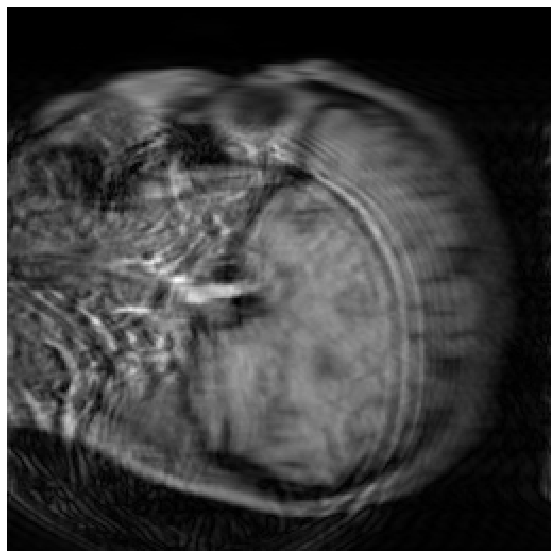

In [61]:
import matplotlib.pyplot as plt
one = get(1, 0, 100)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(one[0][0], cmap="gray")
plt.show()

tensor(1)


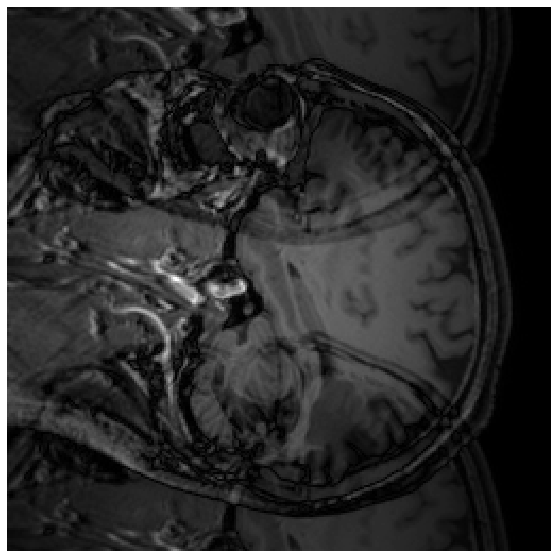

diff


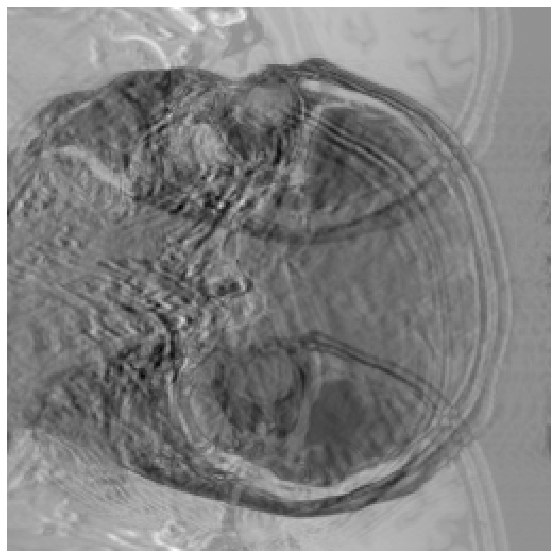

In [62]:
import matplotlib.pyplot as plt
one = get(1, 1, 100)
print(one[1])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(one[0][0], cmap="gray")
plt.show()

print("diff")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(one[0][0] - clean[0][0] , cmap="gray")
plt.show()

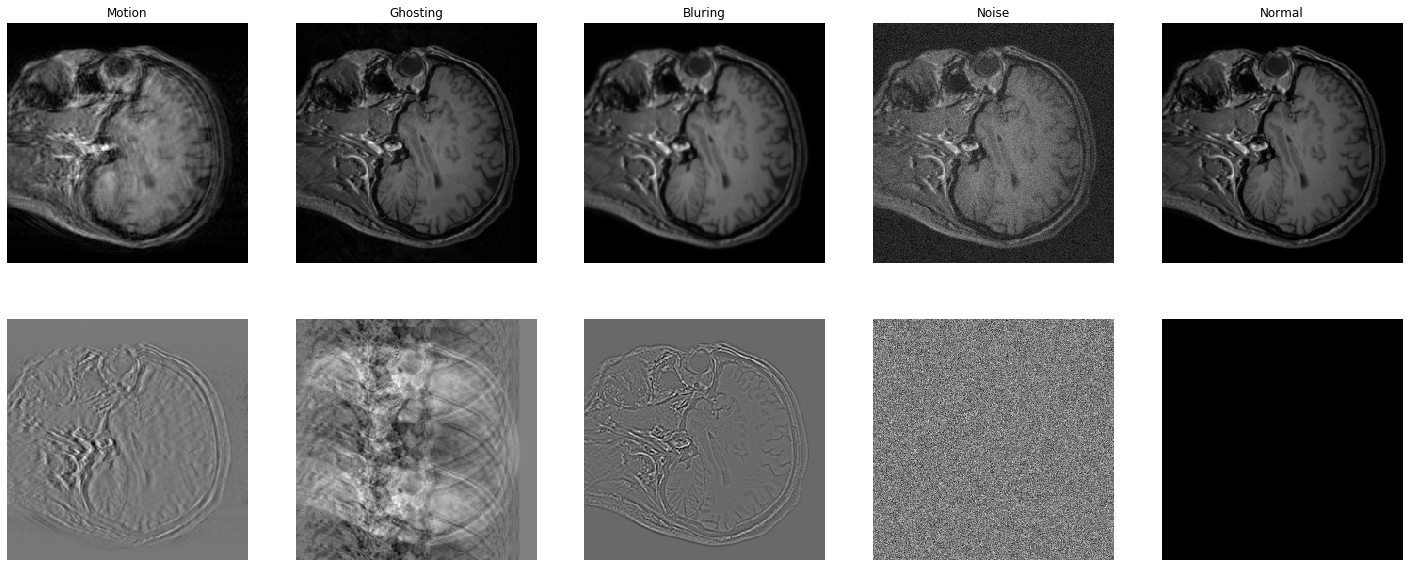

In [71]:
clean = get(1, 5, 100)
titles = ["Motion", "Ghosting", "Bluring", "Noise", "Normal"]

fig, axs = plt.subplots(2, 5, figsize=(25,10))
for i in range(5):
    one = get(1, i, 100)
    
    axs[0, i].imshow(one[0][0], cmap="gray")
    axs[0, i].set_title(titles[i])
    axs[1, i].imshow(clean[0][0] - one[0][0], cmap="gray")
    axs[0, i].axis('off')
    axs[1, i].axis('off')

In [2]:
confusion = [[701,  40 ,  4,   0,  30],
 [ 17, 813,   0,   0,  32],
 [  5,  21, 793,   0 , 62],
 [  0,   0,   0, 848,   7],
 [  1,  13,   0,   0, 863]]

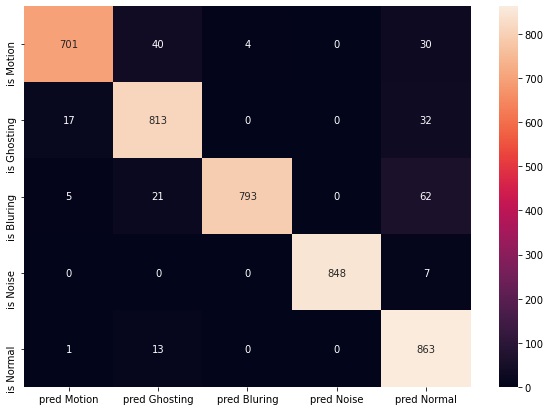

In [11]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(confusion, index = [i for i in ["is Motion", "is Ghosting", "is Bluring", "is Noise", "is Normal"]],
                  columns = [i for i in ["pred Motion", "pred Ghosting", "pred Bluring", "pred Noise", "pred Normal"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

# Plot Networks

In [1]:
from networks import ClassicCNN, CatNet

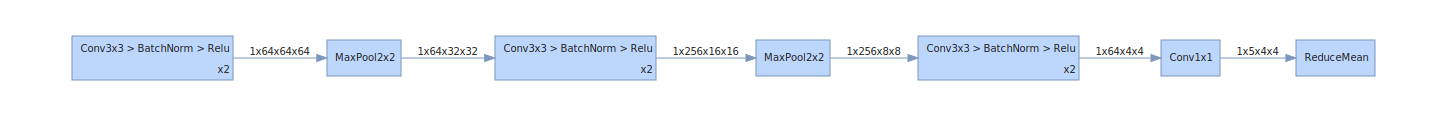

In [2]:
import torch
import hiddenlayer as hdl
model = ClassicCNN(num_classes=5)

hl_graph = hdl.build_graph(model, torch.zeros([1, 1, 255, 255]))
hl_graph.theme = hdl.graph.THEMES["blue"].copy()

hl_graph

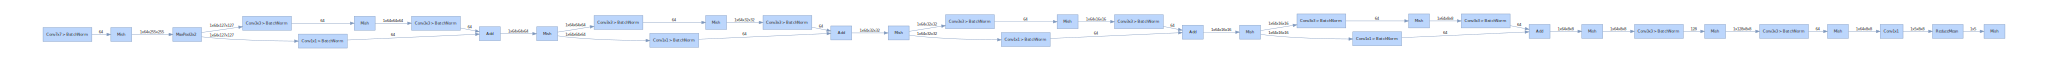

In [14]:
import torch
import hiddenlayer as hdl
model = CatNet(num_classes=5)

transforms = [
    # Fold Conv, BN, RELU layers into one
    hdl.transforms.Fold("Softplus > Tanh > Mul", "Mish", "Mish"),
    hdl.transforms.Fold("Conv > BatchNorm", "defConv"),
    hdl.transforms.Fold("Conv > BatchNorm > Mish > Conv > BatchNorm", "skip")
]

hl_graph = hdl.build_graph(model, torch.zeros([1, 1, 255, 255]), transforms=transforms)
hl_graph.theme = hdl.graph.THEMES["blue"].copy()

hl_graph